In [ ]:
# Note: Please follow to the About Fastai section in the README to update the fastai accordingly

In [1]:
from fastai.tabular.all import *

In [2]:
# for feature generation and plotting
from cryspnet.utils import *
# for accessing some pre-defined constant
from cryspnet.config import *

In [3]:
import pandas as pd
import numpy as np

In [ ]:
@patch
def setups(self:FillMissing, dsets):
    missing = pd.isnull(dsets.conts).any()
    store_attr(but='dsets', na_dict={n:self.fill_strategy(dsets[n], self.fill_vals[n]) for n in missing[missing].keys()})
    self.fill_strategy = self.fill_strategy.__name__

In [4]:
ls ../demo

demo.csv  demo_metal.csv  demo_oxide.csv  demo_train.csv


In [4]:
df = pd.read_csv("../demo/demo_train.csv")

In [5]:
df.head()

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma
0,C4Hf1Ta2U1,225,cubic (F),4.615,4.615,4.615,90.0,90.0,90.0
1,Co1Sb1Ta1,216,cubic (F),5.883,5.883,5.883,90.0,90.0,90.0
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.951,5.951,5.951,90.0,90.0,90.0
3,C1Ni1,225,cubic (F),4.077,4.077,4.077,90.0,90.0,90.0
4,Ir7Mg44,216,cubic (F),20.097,20.097,20.097,90.0,90.0,90.0


# Generate features with matminer

In [6]:
fgenerator = FeatureGenerator()

In [7]:
df_predictors = fgenerator.generate(df)

StrToComposition:   0%|          | 0/280 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/280 [00:00<?, ?it/s]

In [8]:
df_predictors

,formula,Space Group,Bravais,a,b,c,alpha,beta,gamma,composition,...,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,NComp
0,C4Hf1Ta2U1,225,cubic (F),4.6150,4.6150,4.6150,90.000,90.000,90.000,"(C, Hf, Ta, U)",...,0,0.0,0,0,0,0,0,0,0,4
1,Co1Sb1Ta1,216,cubic (F),5.8830,5.8830,5.8830,90.000,90.000,90.000,"(Co, Sb, Ta)",...,0,0.0,0,0,0,0,0,0,0,3
2,Ge0.8Sb0.133Se0.133Te0.867,225,cubic (F),5.9510,5.9510,5.9510,90.000,90.000,90.000,"(Ge, Sb, Se, Te)",...,0,0.0,0,0,0,0,0,0,0,4
3,C1Ni1,225,cubic (F),4.0770,4.0770,4.0770,90.000,90.000,90.000,"(C, Ni)",...,0,0.0,0,0,0,0,0,0,0,2
4,Ir7Mg44,216,cubic (F),20.0970,20.0970,20.0970,90.000,90.000,90.000,"(Ir, Mg)",...,0,0.0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Mo1Nd2O10Se2,2,triclinic (P),5.3582,6.8922,12.5760,85.802,83.970,70.070,"(Mo, Nd, O, Se)",...,0,0.0,0,0,0,0,0,0,0,4
276,C4K3N4O2Re1,2,triclinic (P),7.4700,7.5970,6.3290,105.370,110.200,114.630,"(C, K, N, O, Re)",...,0,0.0,0,0,0,0,0,0,0,5
277,H278As8Na40O420Sm6W80,2,triclinic (P),20.6818,22.2615,25.1353,99.320,96.591,109.036,"(H, As, Na, O, Sm, W)",...,0,0.0,0,0,0,0,0,0,0,6
278,H2Cs1O12P3Zn3,2,triclinic (P),5.1636,8.0324,14.8009,95.796,90.315,108.078,"(H, Cs, O, P, Zn)",...,0,0.0,0,0,0,0,0,0,0,5


In [11]:
trn_cols = ["Bravais"] + list( df_predictors.columns[10:] )

In [12]:
trn_cols[:5]

['Bravais',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number']

# Train for ensembling

In [14]:
# the initializer is a warpper for creating a learner
def initializer(df, dep_var, cont_names=[], cat_names=[], classes=None, k=3, p=0.1, is_oversample=False, n_oversample=None, bs=32):

    # split train and validation set and do oversampling if enabled
    val_idx= np.random.choice(df.index, int(len(df)*p), replace=False)
    if is_oversample:
        df, val_idx = oversample(df, val_idx, dep_var, nsamples=n_oversample)
    
    splits = IndexSplitter(val_idx)(df.index)
    
    # categorize the dep_var : here is the bravais lattice
    
    if classes is None:
        classes = df[dep_var].unique()
        classes.sort()
    
    df[dep_var] = pd.Categorical(df[dep_var], categories=classes)
        
    # create datasets
    trn_cols = list(cont_names) + list(cat_names) + [dep_var]
    
    to = TabularPandas(df[trn_cols], procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_names, # categories columns name
                   cont_names = cont_names, # continuous columns name
                   y_names=dep_var,
                   splits=splits)
    
    # turn it into dataloader
    dls = to.dataloaders(bs=bs)
    
    # use the dataset to create the corresponding tabular learner
    # config allow us to tune the actual architecture
    config = tabular_config(ps=[0.0] + [0.1] * 4, bn_cont=False, bn_final=True) # add drop out layer

    # metrics are for evaluation
    k = min(len(classes), k)    
    metrics = [partial(topkacc, k=k), accuracy]
    
    # create learner
    learn = tabular_learner(
        dls,
        layers=[256, 256, 256, 256], # set layer dimension
        metrics=metrics,
        config=config)
    
    learn.classes = df[dep_var].cat.categories
    
    return learn

## Training for one model

In [16]:
learn = initializer(
    df_predictors, 
    dep_var="Bravais",
    cont_names=trn_cols[1:],
    classes=BRAVAIS_LATTICE,
    is_oversample=True,
    n_oversample=400,
    bs = 32,
)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.015848932787775993)

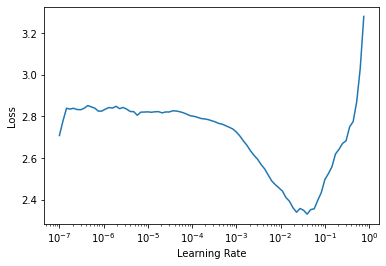

In [18]:
learn.lr_find()

In [20]:
# select a learning rate that is slightly higher than the suggestion setting
learn.fit_one_cycle(10, lr_max=1e-2)

# of course the accuracy is gonna be low by nature

epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.219453,4.081230,0.370370,0.222222,00:01
1,1.144657,4.460364,0.333333,0.259259,00:00
2,0.826326,4.872546,0.444444,0.333333,00:00
3,0.512160,4.047669,0.592593,0.370370,00:01
4,0.388842,5.038612,0.444444,0.370370,00:01
5,0.265585,5.553104,0.481481,0.296296,00:01
6,0.157702,5.515595,0.518519,0.222222,00:01
7,0.079881,6.094183,0.333333,0.185185,00:00
8,0.047803,6.201541,0.481481,0.259259,00:00
9,0.035141,6.470513,0.481481,0.185185,00:01


## Training Multiple Model

In [24]:
from pathlib import Path

In [29]:
LEARNER

'/home/aurora/cryspnet/cryspnet/learner/'

In [32]:
learner_folder = Path(LEARNER)
learner_folder.mkdir(exist_ok=True)
# metal or oxide subset is similar but just replace whole with metal or oxide
bravais_folder = learner_folder / BRAVAIS_MODELS_FOLDER['whole']
bravais_folder.mkdir(exist_ok=True)

epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.197575,1557467.500000,0.333333,0.148148,00:00
1,1.026458,41415660.000000,0.296296,0.185185,00:00
2,0.797319,46087136.000000,0.296296,0.148148,00:00
3,0.520881,26072534.000000,0.259259,0.185185,00:00
4,0.302055,48354712.000000,0.259259,0.111111,00:00
5,0.236456,33866696.000000,0.259259,0.111111,00:00
6,0.124083,37928496.000000,0.296296,0.148148,00:00
7,0.081683,48455060.000000,0.296296,0.148148,00:00
8,0.040895,49358876.000000,0.259259,0.148148,00:00
9,0.031846,54819492.000000,0.296296,0.148148,00:00


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.217629,4.301156,0.370370,0.185185,00:00
1,1.030853,7.166342,0.222222,0.111111,00:00
2,0.822579,6.718381,0.259259,0.148148,00:00
3,0.527529,7.081852,0.259259,0.185185,00:00
4,0.362049,7.249446,0.407407,0.185185,00:00
5,0.206490,7.216198,0.333333,0.185185,00:00
6,0.156552,8.054197,0.370370,0.148148,00:00
7,0.071952,7.594308,0.296296,0.185185,00:00
8,0.058084,7.793068,0.259259,0.148148,00:00
9,0.034064,7.766898,0.333333,0.148148,00:00


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.247049,3.563869,0.518519,0.185185,00:00
1,1.090633,5.988949,0.222222,0.222222,00:00
2,0.795312,5.898208,0.333333,0.185185,00:00
3,0.560312,5.195646,0.444444,0.259259,00:00
4,0.354450,7.537277,0.370370,0.148148,00:00
5,0.206225,6.065253,0.333333,0.148148,00:00
6,0.131914,6.025358,0.370370,0.111111,00:00
7,0.094111,6.175436,0.333333,0.148148,00:00
8,0.047150,6.677561,0.296296,0.148148,00:00
9,0.028289,6.623797,0.259259,0.148148,00:00


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.212188,197578.906250,0.296296,0.111111,00:00
1,1.079427,8242915.000000,0.370370,0.148148,00:00
2,0.777007,8444685.000000,0.333333,0.148148,00:00
3,0.498920,191140.140625,0.333333,0.111111,00:00
4,0.344312,40139984.000000,0.444444,0.222222,00:00
5,0.228636,95943952.000000,0.259259,0.148148,00:00
6,0.191754,34805028.000000,0.481481,0.185185,00:00
7,0.114586,88917184.000000,0.481481,0.222222,00:00
8,0.053545,16797642.000000,0.518519,0.185185,00:00
9,0.029949,55126640.000000,0.481481,0.148148,00:00


epoch,train_loss,valid_loss,topkacc,accuracy,time
0,1.211452,5.087793,0.222222,0.185185,00:00
1,1.128150,6.107784,0.222222,0.037037,00:00
2,0.798991,5.230563,0.296296,0.148148,00:00
3,0.579498,7.254058,0.333333,0.111111,00:00
4,0.361184,6.659317,0.407407,0.222222,00:00
5,0.227470,9.012223,0.259259,0.074074,00:00
6,0.139670,7.881444,0.333333,0.074074,00:00
7,0.080562,8.189998,0.222222,0.074074,00:00
8,0.049198,8.962470,0.148148,0.037037,00:00
9,0.033644,8.965880,0.259259,0.037037,00:00


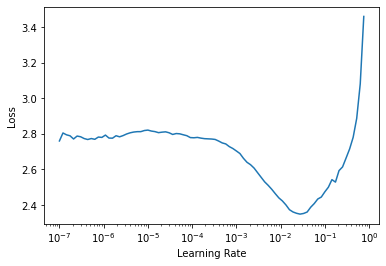

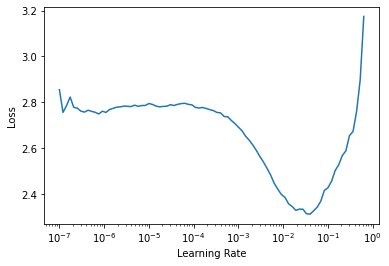

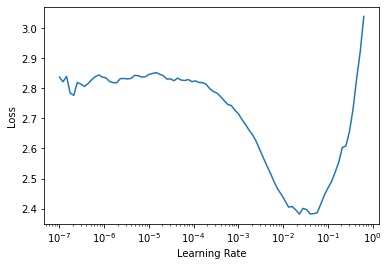

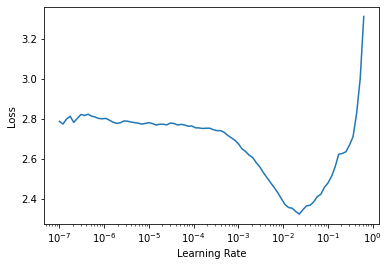

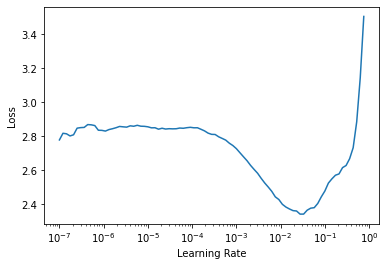

In [34]:
n_ensembler = 5

for i in range(n_ensembler):
    learn = initializer(
        df_predictors, 
        dep_var="Bravais",
        cont_names=trn_cols[1:],
        classes=BRAVAIS_LATTICE,
        is_oversample=True,
        n_oversample=400,
        bs = 32,
    )

    suggestions = learn.lr_find()

    # you can use one of lr setting in the suggestion or define it yourself
    # lr_max = suggestions.lr_min
    lr_max = 1e-2

    learn.fit_one_cycle(10, lr_max=lr_max)

    # save the model to the learner directory
        
    learn.export(bravais_folder / f"{BRAVAIS_ENSEMBLER_PREFIX}{i}.pkl")